# Comparing Calculated Lattice Parameters of Elemental Materials with the Materials Project
## This DFTman example will walk you through the steps of running and analyzing a set of simulations with quantumESPRESSO  pw.x on material data retrieved from the Materials Project
## The main steps are:
* Configuring and running a Materials Project query
* Configuring quantumESPRESSO input
* Creating `PWCalculation` objects and inserting them into the DFTman database
* Submitting `PWCalculation`s to nanoHUB to be run
* Watching the status of simulations on nanoHUB and in DFTman
* Parsing `PWCalculation`s and updating the DFTman database
* Using data parsed from the pw.x XML output to plot calculated materials properties against what the Materials Project reports

In [1]:
import qgrid  # pretty JS tables
import sys  # filesystem checks
import os  # filesystem checks
from hublib import use  # nanoHUB module
import pathlib as pl  # filesystem checks
import numpy as np  # data and math
import matplotlib.pyplot as plt  # plotting
%matplotlib inline

# DFTman library
sys.path.append('../../lib')
from DFTman import *

# load pw.x into the local environment
%use espresso-6.2.1

PROJECT = os.getcwd().split('/')[-1]  # determine the current project

# Query Materials Project
## Retrieve materials structures and properties in order to configure DFT simulations

In [7]:
# Queries to the Materials Project use MongoDB syntax, documented here:
#     https://docs.mongodb.com/manual/tutorial/query-documents/
# Available criteria and properties are documented by the Materials Project here:
#     https://materialsproject.org/wiki/index.php/The_Materials_API#query

API = 'S9hWiT7PopFD4aUH'  # This is the API key linked to your Materials Project account
criteria = {
    'nelements': 1,  # exactly one uniqe element in each material
    'nsites': {'$lt': 5},  # less than 5 sites in each unit cell
    'e_above_hull': {'$gte': 0.0, '$lte': 0.0},  # energy above the convex hull '$gte' <= E (eV) <= '$lte'
    'elements': {'$in': ['Al', 'Cu', 'Mo', 'Si']},  # set of elements which may be in each material
    'spacegroup.number': {'$in': [225, 227, 229]}  # set of spacegroups which each material may have
}

# The MPQuery class retrieves some default properties (material_id, pretty_formula, structure, elements), but
#     you can add additional properties here
additional_properties = ['run_type', 'spacegroup.number', 'e_above_hull'] 

m = MPQuery(criteria, additional_properties, API)
query_data = m.query()
data = query_data.copy()

m.display()

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defaultColumnWidth': 150, 'rowHeight': 28, 'enableColumnReorder': False, 'enableTextSelectionOnCells': True, 'editable': True, 'autoEdit': False, 'explicitInitialization': True, 'maxVisibleRows': 15, 'minVisibleRows': 8, 'sortable': True, 'filterable': True, 'highlightSelectedCell': False, 'highlightSelectedRow': True}, id='9015f892-bf1b-44bf-89c5-04bc2cc4a8ed', precision=5)

In [6]:
# This cell deletes the copy of the query data from above so that when you run the rest of the example,
#     you don't submit any simulations
data = []

# Specify QE Input
## Configure the DFT code for your simulations

In [8]:
# Documentation for pw.x input is here:
#     https://www.quantum-espresso.org/Doc/INPUT_PW.html

control = {
    # OMIT 'title', 'outdir', and 'max_seconds'! They will be overwritten if set.
    'calculation'                       :    'vc-relax',
    'verbosity'                         :    'high',
    # 'disk_io'                           :    'none',
}
system = {
    # OMIT 'nat', 'ntyp'! They will be overwritten if set.
    'ibrav'                             :    0,
    'ecutwfc'                           :    30.0,
    'occupations'                       :    'smearing',
    'degauss'                           :    0.010,
    'smearing'                          :    'mv',
}
electrons = {
    'electron_maxstep'                  :    500,
    'conv_thr'                          :    1.0e-6,
}
ions = {}
cell = {}
kpoints_mode  = 'automatic'
kpoints_grid  = (8, 8, 8)
kpoints_shift = (0, 0, 0)

# Configure, save, and submit individual simulations
## Choose a pseudopotential family and configure how quantumESPRESSO should be run in nanoHUB

In [9]:
# DFTman provides families of pseudopotentials. Currently installed are the SSSP precision and efficiency families
#     from the Materials Cloud: https://www.materialscloud.org/discover/sssp
PSEUDO_FAMILY = 'efficiency'  # 'precision', 'efficiency'

# nanoHUB provides a few versions of quantum espresso, but we recommend to leave this as-is
ESPRESSO_VERSION = 'espresso-6.2.1_pw'  # espresso-6.2.1_pw

WALLTIME = '02:00:00'  # This is the time each simulation has to run in 'hh:mm:ss' format
NCPUS = 1  # The number of CPUs dedicated to each simulation
TAG = None  # Leave this as None or change it to a string (e.g. 'testtag') to add a tag to your simulation names

## Iterate over all materials from the Materials Project query, tweak individual simulations if necessary, generate simulation metadata, create `PWCalculation`s, and submit to nanoHUB

In [10]:
pwinputs = []
for material in data:
    # Create a pseudopotential dictionary from a given pseudopotential family
    pseudo = nanoHUB_pseudo(material['structure'], pseudo_family=PSEUDO_FAMILY)
    
    # Customize pw.x input data for each specific material
    # reduce degauss (smearing) when `vc-relax`ing Si because it is not a metal:
    custom_system = system.copy()
    if 'Si' in material['elements']:
        custom_system['degauss'] = 0.001
    # increase ecutwfc for Cu because its pseudopotential recommends 55.0 Ry:
    if 'Cu' in material['elements']:
        custom_system['ecutwfc'] = 55.0
    # Then, replace '''system''' in the PWInputDFTman call below with your new '''custom_system''' |v|
    
    # Create a PWInputDFTman object which represents a pw.x input file
    pwinput = PWInputDFTman(material['structure'],
                            pseudo=pseudo,
                            control=control,
                            system=custom_system,  # using custom_system instead of system |^|
                            electrons=electrons,
                            ions=ions,
                            cell=cell,
                            kpoints_mode=kpoints_mode,
                            kpoints_grid=kpoints_grid,
                            kpoints_shift=kpoints_shift)
    
    # Generate the metadata necessary for a nanoHUB submission
    metadata = pwmetadataDFTman(PROJECT, pwinput, pseudo_family=PSEUDO_FAMILY, espresso_version=ESPRESSO_VERSION,
                                walltime=WALLTIME, ncpus=NCPUS, tag=TAG)
    
    # Make sure all the query data is in a json-able format (dictionaries are good, objects are generally bad)
    #    and then add the query data to the metadata dictionary
    material['structure'] = material['structure'].as_dict()  # Structure object -> dictionary
    metadata['mp_data'] = material
    
    # Create a PWCalculationDFTman object which represents a full pw.x simulation
    #    including input, output, and metadata
    # This is the final step in configuring each simulation
    pwcalculation = PWCalculationDFTman(pwinput, metadata)
    
    # Insert the configured PWCalculationDFTman into the database
    doc_id = pwcalculation.db_insert()
    
    # Submit the pw.x calculation to nanoHUB
    submit_result = pwcalculation.submit()

# Watch simulation status

In [21]:
# Set watch=True to auto-refresh the status every delay seconds
nanoHUB_status(PROJECT, watch=False, delay=5)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defaultColumnWidth': 150, 'rowHeight': 28, 'enableColumnReorder': False, 'enableTextSelectionOnCells': True, 'editable': True, 'autoEdit': False, 'explicitInitialization': True, 'maxVisibleRows': 15, 'minVisibleRows': 8, 'sortable': True, 'filterable': True, 'highlightSelectedCell': False, 'highlightSelectedRow': True}, id='4cdaf20d-a144-41a7-adcb-cba9b66cfb06', precision=5)

# Parse the PWCalculation and update its data in TinyDB

In [22]:
# Whether to update the database after parsing data. You may not want to save the parsed data immediately
#     especially if you want to keep a clean database
UPSERT = False 

# In order to query the database for Complete simulations, we need to load the database and the table with
#     our data. Think of this as an excel file (database) and book in the spreadsheet (table).
db = tinydb.TinyDB('dftman.json')  # the database file is always 'dftman.json'
table = db.table(PROJECT)  # the table is always the name of the project (see the first cell to see where PROJECT comes from)

query = tinydb.Query()  # this Query object is what we use to search the database

# Here, we want all simulations which are complete. This information is stored in
#     the metadata of the PWCalculation under the name nanoHUB_status.
complete_pwcalcs = table.search(query.metadata.nanoHUB_status == 'Complete')

# The PWCalculation is stored as a dictionary in the database, so we convert them back to
#     PWCalculation objects
complete_pwcalcs = [PWCalculationDFTman.from_dict(pwcalc) for pwcalc in complete_pwcalcs]

# For each calculation, if the proper files exist, we parse them
for pwcalc in complete_pwcalcs:
    output = pwcalc.parse_output()  # Parse the standard output
    if pl.Path(pwcalc.metadata['xml_path']).exists():
        xml = pwcalc.parse_xml()  # Parse the XML output
    if UPSERT:  # Update the calculation in the database if requested
        pwcalc.db_upsert()

../../lib/pypwio/PWOutput.py:121: UserWarning: The FFT grid is incommensurate, so some symmetries may be lost.
  warnings.warn('The FFT grid is incommensurate, so some symmetries may be lost.')


# Plot the Materials Project lattice parameters against the pw.x results

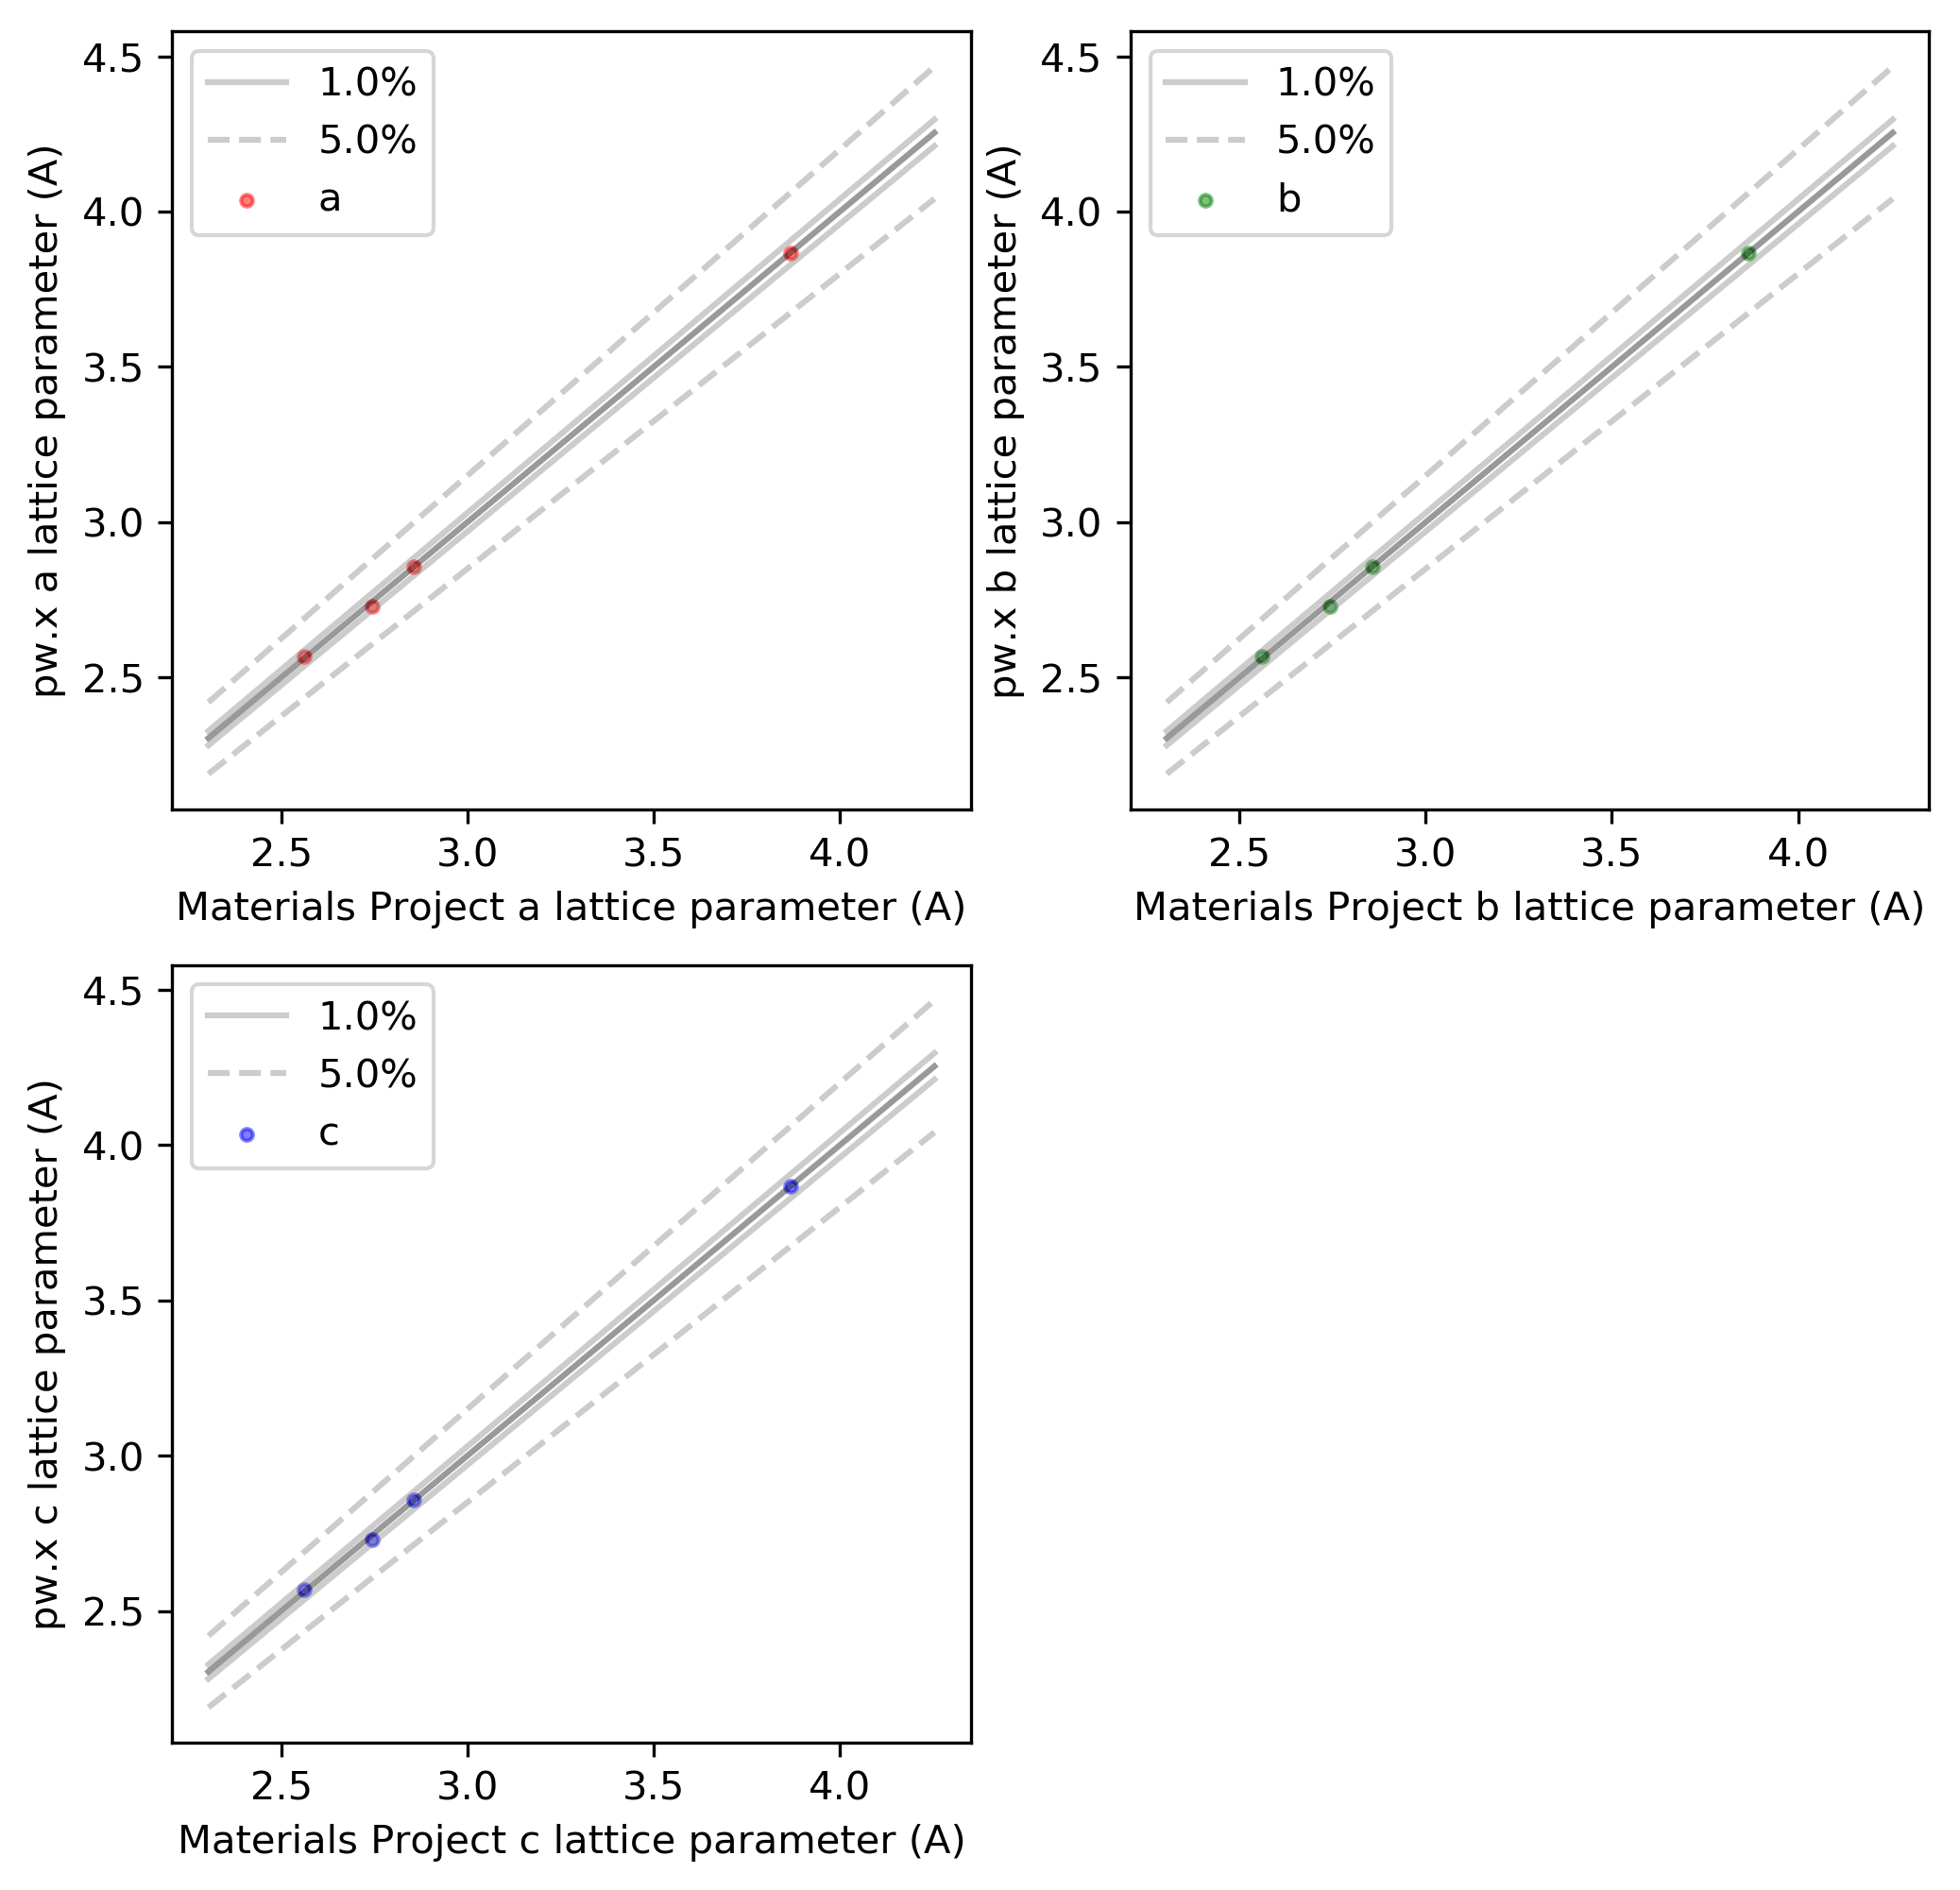

In [36]:
# To see all the available data in the parsed XML and standard output,
#     check the pypwio documentation and source code: https://github.com/zooks97/pypwio

# Retrieve lattice information from pwcalculation objects
result_lp, matproj_lp, formula = [], [], []
for pwcalc in complete_pwcalcs:
    result_lat = pwcalc.pwoutput.final_structure['lattice']
    result_lp.append([result_lat['a'], result_lat['b'], result_lat['c']])
    
    matproj_lat = pwcalc.metadata['mp_data']['structure']['lattice']
    matproj_lp.append([matproj_lat['a'], matproj_lat['b'], matproj_lat['c']])
    
    formula.append(pwcalc.metadata['mp_data']['pretty_formula'])

# Put lattice parameters in a numpy array
result_lp = np.array(result_lp)
matproj_lp = np.array(matproj_lp)
all_lp = np.vstack(np.array([result_lp, matproj_lp]))

# Specify the number of plots (2x2 to fit 3 subplots)
fig, axes = plt.subplots(2, 2)

# Set DPI and figure size to make the plots clear
fig.set_dpi(300)
fig.set_figwidth(8)
fig.set_figheight(8)

# Plot the a lattice parameters on the top left
# Take 90% of the minimum and 110% of the maximum parameter to set limits on the y=x line
a_limits = np.array([0.9*np.min(all_lp[:,0]), 1.1*np.max(all_lp[:,0])])
# Plot the y=x line
axes[0, 0].plot(a_limits, a_limits, alpha=0.4, color='k')
# Plot the +-1% and +-5% error lines
for err, l in {0.01: '-', 0.05: '--'}.items():
    axes[0, 0].plot(a_limits, (1+err)*a_limits, alpha=0.4, color='grey', linestyle=l, label='{}%'.format(err*100))
    axes[0, 0].plot(a_limits, (1-err)*a_limits, alpha=0.4, color='grey', linestyle=l)
# Plot the parameter data (1st column of matproj and result parameter arrays)
axes[0, 0].scatter(matproj_lp[:,0], result_lp[:,0], alpha=0.5, marker='.', label='a', color='r')
# Label the axes and add the legend
axes[0, 0].set_xlabel('Materials Project a lattice parameter (A)')
axes[0, 0].set_ylabel('pw.x a lattice parameter (A)')
axes[0, 0].legend()

# Plot the b lattice parameters on the top right
b_limits = np.array([0.9*np.min(all_lp[:,1]), 1.1*np.max(all_lp[:,1])])
axes[0, 1].plot(b_limits, b_limits, alpha=0.4, color='k')
for err, l in {0.01: '-', 0.05: '--'}.items():
    axes[0, 1].plot(b_limits, (1+err)*b_limits, alpha=0.4, color='grey', linestyle=l, label='{}%'.format(err*100))
    axes[0, 1].plot(b_limits, (1-err)*b_limits, alpha=0.4, color='grey', linestyle=l)
axes[0, 1].scatter(matproj_lp[:,1], result_lp[:,1], alpha=0.5, marker='.', label='b', color='g')
axes[0, 1].set_xlabel('Materials Project b lattice parameter (A)')
axes[0, 1].set_ylabel('pw.x b lattice parameter (A)')
axes[0, 1].legend()

# Plot the c lattice parameters on the bottom left
c_limits = np.array([0.9*np.min(all_lp[:,2]), 1.1*np.max(all_lp[:,2])])
axes[1, 0].plot(c_limits, c_limits, alpha=0.4, color='k')
for err, l in {0.01: '-', 0.05: '--'}.items():
    axes[1, 0].plot(c_limits, (1+err)*c_limits, alpha=0.4, color='grey', linestyle=l, label='{}%'.format(err*100))
    axes[1, 0].plot(c_limits, (1-err)*c_limits, alpha=0.4, color='grey', linestyle=l)
axes[1, 0].scatter(matproj_lp[:,2], result_lp[:,2], alpha=0.5, marker='.', label='c', color='b')
axes[1, 0].set_xlabel('Materials Project c lattice parameter (A)')
axes[1, 0].set_ylabel('pw.x c lattice parameter (A)')
axes[1, 0].legend()

# Hide the bottom right plot
axes[1, 1].set_visible(False)

# Show and close the plot
plt.show()
plt.close()